## Dual Governance Agent-based modelling



In [1]:
%pip show radcad

Name: radcad
Version: 0.13.0
Summary: A Python package for dynamical systems modelling & simulation, inspired by and compatible with cadCAD
Home-page: 
Author: CADLabs
Author-email: benschza@users.noreply.github.com
License: 
Location: /opt/anaconda3/envs/my-conda-env/lib/python3.12/site-packages
Requires: fn-py, numpy, pandas, pathos, py
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Dependences
import pandas as pd
import numpy as np

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

# Experiments
from model import run
from model.parts.utils import *

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

In [3]:
from model.state_variables import initial_state
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params

MONTE_CARLO_RUNS = 1
TIMESTEPS = 100

model = Model(
    initial_state=initial_state,
    params=sys_params,
    state_update_blocks=state_update_blocks,
)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=MONTE_CARLO_RUNS)

result = simulation.run()
df = pd.DataFrame(result)
rdf = run.postprocessing(df)

In [4]:
df.head()

,actors,dg,proposals_type,time_manager,simulation,subset,run,substep,timestep
0,[StHolderActor(address='0x93c4b944d05dfe6df764...,DualGovernance(state=DualGovernanceState(confi...,{},TimeManager(current_time=datetime.datetime(202...,0,0,1,0,0
1,[StHolderActor(address='0x93c4b944d05dfe6df764...,DualGovernance(state=DualGovernanceState(confi...,{},TimeManager(current_time=datetime.datetime(202...,0,0,1,1,1
2,[StHolderActor(address='0x93c4b944d05dfe6df764...,DualGovernance(state=DualGovernanceState(confi...,{},TimeManager(current_time=datetime.datetime(202...,0,0,1,2,1
3,[StHolderActor(address='0x93c4b944d05dfe6df764...,DualGovernance(state=DualGovernanceState(confi...,{},TimeManager(current_time=datetime.datetime(202...,0,0,1,3,1
4,[StHolderActor(address='0x93c4b944d05dfe6df764...,DualGovernance(state=DualGovernanceState(confi...,{},TimeManager(current_time=datetime.datetime(202...,0,0,1,4,1


In [5]:
rdf.head()

,timestep,run,proposals_submited_count,proposals_executed_count,dg_state,current_time,rqs
4,1,1,0,0,2,2024-08-11 22:12:01.109058,130743216985805680
8,2,1,0,0,3,2024-08-11 23:12:01.109058,0
12,3,1,0,0,2,2024-08-12 00:12:01.109058,130743216985805680
16,4,1,0,0,3,2024-08-12 01:12:01.109058,0
20,5,1,0,0,2,2024-08-12 02:12:01.109058,130743216985805680


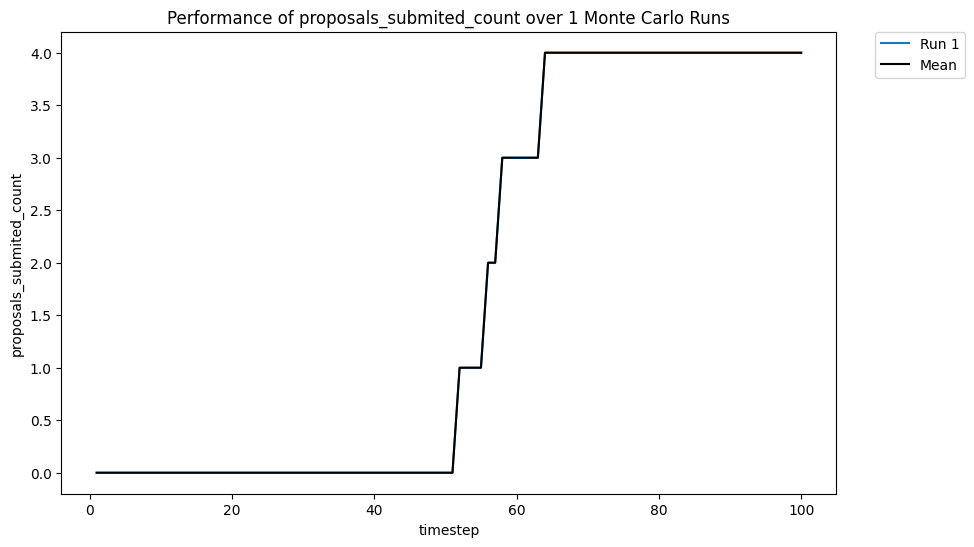

In [6]:
monte_carlo_plot(rdf, "timestep", "timestep", "proposals_submited_count", 1)

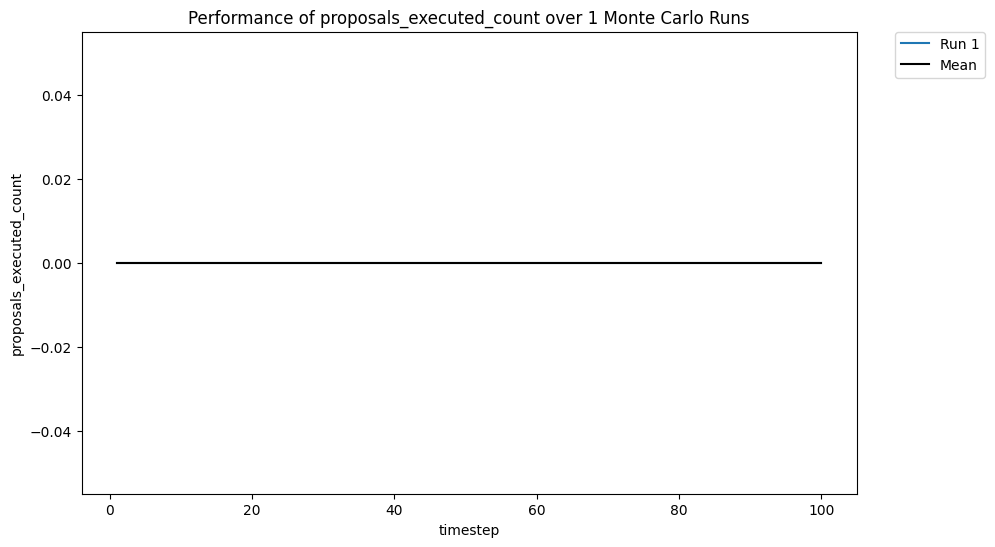

In [7]:
monte_carlo_plot(rdf, "timestep", "timestep", "proposals_executed_count", 1)

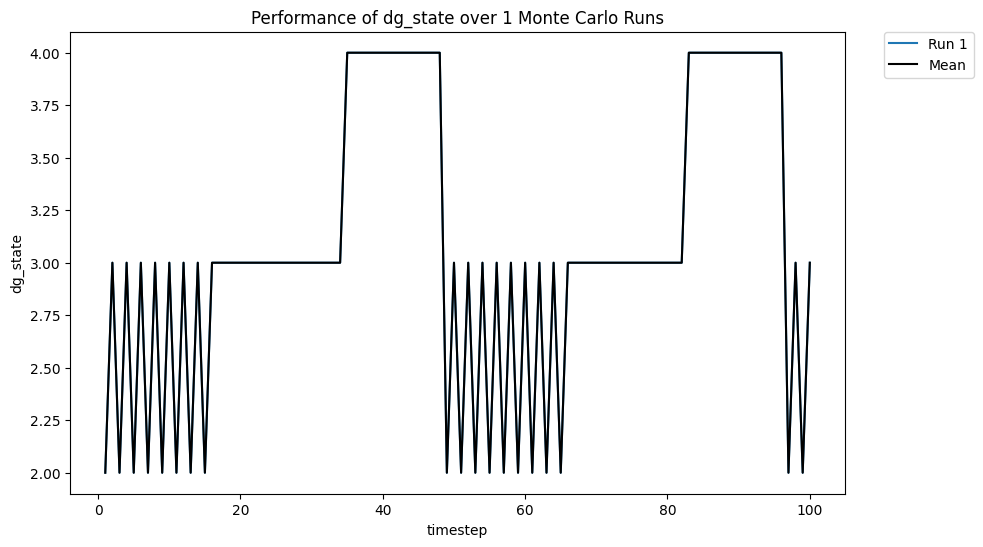

In [8]:
monte_carlo_plot(rdf, "timestep", "timestep", "dg_state", 1)

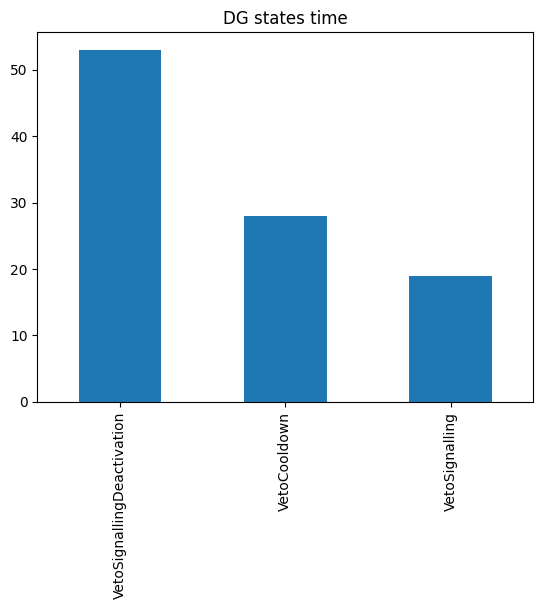

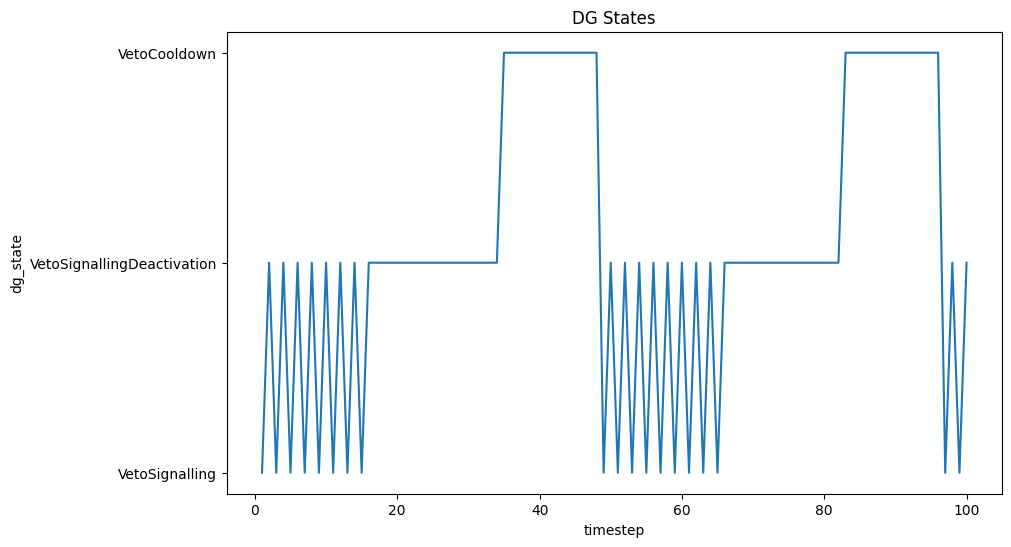

In [9]:
state_plot(rdf, "timestep", "dg_state", 1)

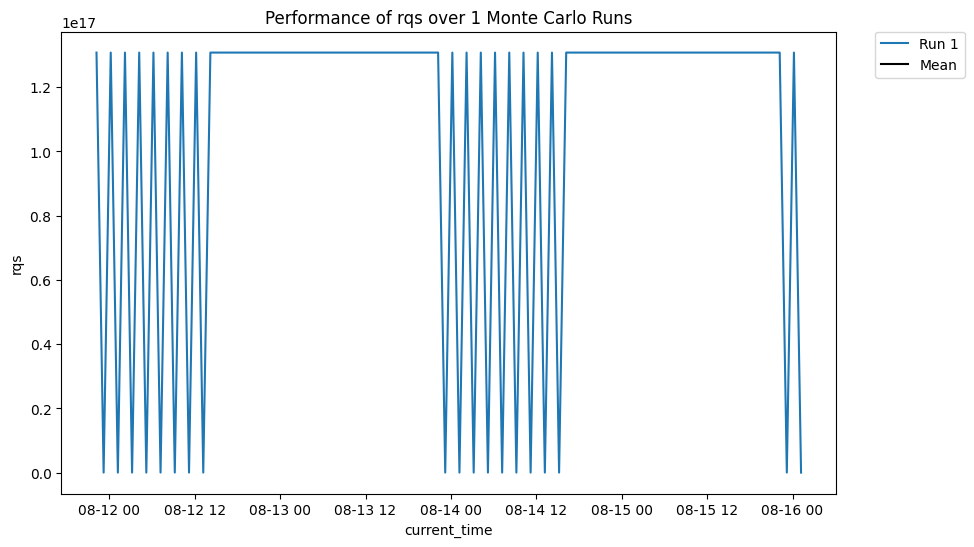

In [10]:
monte_carlo_plot(rdf, "timestep", "current_time", "rqs", 1)